In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

# Pitfalls of a Program Evaluation

So you're going to run a pilot program, and want to make sure that you make informed decisions on whether or not it was successful. Here are some things to keep in mind prior to actually carrying out the pilot.

## The Randomized Control

The gold standard in determining an effect of a treatment (intervention) is the randomized control trial. In this design paradigm subjects (hereafter students) are randomly assigned into categories, one of which is the control group (no intervention). Then, comparing groups, all other factors (study habits, attendence, etc.) are minimized and distributed across groups, and any effect you detect is the result of the treatment. Simple and clear.

Imagine a well performing intervention targeted at underperforming students at a course midpoint. At the midpoint, the intervention starts, and effectively increases their grade by 10 (a good intervention indeed!). We randomly assign students to the treatment (with a 50/50 chance) who score under 55% at the decision point.

We are simply asking: since everything else is evenly distributed, what is the effect of our program on the grades of students?

Program --> Grade

In our very simple example, we can easily detect a modest effect because we can compare the [could have been piloted] students to [were piloted] students:

In [2]:
# Common variables

n=1000 # number of students
m=65 # course mean
v=10 # sd spread of the grades around the mean
deltam=5 # how much a grade can change 'randomly' between start and end of the pilot
deltav=10 # sd or the change
threshold = 55 # at what point do we start putting students in the treatment

pilot_effect= 10 # how much a grade is improved with the intervention

nrand=500

def make_student_dist(n,all_treatment,threshold,pilot_effect):
    students=pd.DataFrame(index=np.arange(n),columns=['Grade','Treatment','Post-Grade'])
    students['Grade']=np.random.normal(m,v,n)
    students['Treatment']=0
    students['Treatment'].loc[students['Grade']<threshold]=1
    if not all_treatment:
        students['Treatment']=students['Treatment']*np.random.randint(0,2,n)
    students['Post-Grade']=students['Grade']+\
    np.random.normal(deltam,deltav,n)+pilot_effect*students['Treatment']

    students['Grade'].loc[students['Grade']>100]=100
    students['Post-Grade'].loc[students['Post-Grade']>100]=100
    students['Grade']=students['Grade'].astype(np.float32).copy(True)
    students['Grade'].loc[students['Grade']<0]=0
    students['Post-Grade'].loc[students['Post-Grade']<0]=0
    students['Post-Grade']=students['Post-Grade'].astype(np.float32).copy(True)
    students['Distance']=students['Grade']-threshold
    return students

Running bootstraps
 500/500 
Plotting the last bootstrap (for illustration)


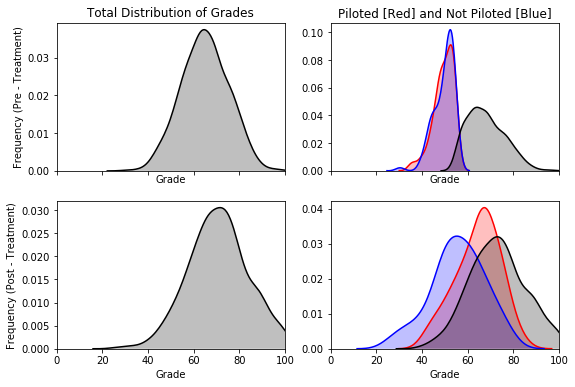

Resampled difference of means between [were piloted] and [could have been piloted]: 10.05


In [3]:
print('Running bootstraps')
samp=np.zeros((nrand,))
for ni in range(nrand):
    print('\r %d/%d' % (ni+1,nrand),end='')
    students=make_student_dist(n,False,threshold,pilot_effect)
    
    students=students.loc[students['Grade']<=threshold].copy(True)
    dm=students[['Treatment','Post-Grade']].groupby('Treatment').mean()
    samp[ni]=dm['Post-Grade'].loc[1]-dm['Post-Grade'].loc[0]

print(' ')
students=make_student_dist(n,False,threshold,pilot_effect)

print('Plotting the last bootstrap (for illustration)')

cmap= sns.color_palette('Set1')
f, axes = plt.subplots(2,2, figsize=(9, 6), sharex=True)

variables=[['Grade','Grade'],['Post-Grade','Post-Grade']]
titles=[['Total Distribution of Grades','Piloted [Red] and Not Piloted [Blue]'],
        ['','']]
y_labels=[['Frequency (Pre - Treatment)',''],['Frequency (Post - Treatment)','']]


for r in range(2):
    for c in range(2):
        if c==0:
            sns.distplot(students[variables[r][c]], hist=False,color='k',kde_kws={"shade": True},ax=axes[r,c])
        else:
            sns.distplot(students[variables[r][c]].loc[students['Treatment']==1], 
                         hist=False, color='r', kde_kws={"shade": True},ax=axes[r,c])
            sns.distplot(students[variables[r][c]].loc[students['Treatment']==0].loc[students['Grade']<threshold], 
                         hist=False, color='b', kde_kws={"shade": True},ax=axes[r,c])
            sns.distplot(students[variables[r][c]].loc[students['Treatment']==0].loc[students['Grade']>=threshold], 
                         hist=False, color='k', kde_kws={"shade": True},ax=axes[r,c])
        axes[r,c].set_title(titles[r][c])
        axes[r,c].set_ylabel(y_labels[r][c])
        axes[r,c].set_xlabel('Grade')
        axes[r,c].set_xlim([0,100])

plt.show()

print('Resampled difference of means between [were piloted] and [could have been piloted]: %.2f' % np.mean(samp))


## No Control

But what happens if (with good intentions) we simply put everyone under the threshold in the pilot program? 


Same scenario, but everyone who scores under 65% is assigned to the treatment.

Running bootstraps
 500/500 
Plotting the last bootstrap (for illustration)


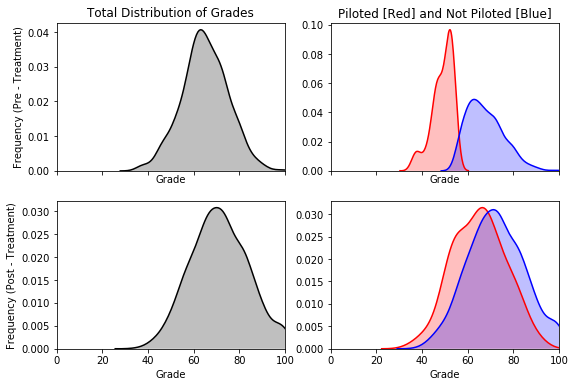

Resampled difference of means between [were piloted] students and [were not piloted] students: -7.97


In [4]:
print('Running bootstraps')
samp=np.zeros((nrand,))
for ni in range(nrand):
    print('\r %d/%d' % (ni+1,nrand),end='')
    students=make_student_dist(n,True,threshold,pilot_effect) # Changed from False
    
    dm=students[['Treatment','Post-Grade']].groupby('Treatment').mean()
    samp[ni]=dm['Post-Grade'].loc[1]-dm['Post-Grade'].loc[0]

print(' ')
students=make_student_dist(n,True,threshold,pilot_effect)
print('Plotting the last bootstrap (for illustration)')

cmap= sns.color_palette('Set1')
f, axes = plt.subplots(2,2, figsize=(9, 6), sharex=True)

variables=[['Grade','Grade'],['Post-Grade','Post-Grade']]
titles=[['Total Distribution of Grades','Piloted [Red] and Not Piloted [Blue]'],
        ['','']]
y_labels=[['Frequency (Pre - Treatment)',''],['Frequency (Post - Treatment)','']]

for r in range(2):
    for c in range(2):
        if c==0:
            sns.distplot(students[variables[r][c]], hist=False,color='k',kde_kws={"shade": True},ax=axes[r,c])
        else:
            sns.distplot(students[variables[r][c]].loc[students['Treatment']==1], 
                         hist=False, color='r', kde_kws={"shade": True},ax=axes[r,c])
            sns.distplot(students[variables[r][c]].loc[students['Treatment']==0], 
                         hist=False, color='b', kde_kws={"shade": True},ax=axes[r,c])
        axes[r,c].set_title(titles[r][c])
        axes[r,c].set_ylabel(y_labels[r][c])
        axes[r,c].set_xlabel('Grade')
        axes[r,c].set_xlim([0,100])

plt.show()

print('Resampled difference of means between [were piloted] students and [were not piloted] students: %.2f' % np.mean(samp))


We've helped more students, but now we can only compare (unfairly) the piloted to non piloted, which gives us a dissapointing (and very misleading) estimate of how much we helped!

## Recovering the Simple Effect

In a desire to help, it is tempting to target an program to those who need it/will benefit from it the most. Morally, an intervention to help struggling students should not simply let a control group flounder.

At the same time, we need to prioritize and identify the interventions that do the most good.

But How?

There are many ways, but they all require some forethought and planning (as well as some assumptions to be trust-worthy). One design that lends itself to our simple example is a Regression Discontinuity Design. In effect, we assume that a student who scores a 64% is not that different from a student who scores a 66%, it was just 'random chance' that put them on one side of the border or the other. In effect, at the border we have a randomized control design, it is simply that 'we' were not the ones who rolled the dice.

So let's look at the grade breakdown at the border. For simplicity we are just looking at the difference of the slopes' intercept at the threshold.



Running bootstraps
 500/500 


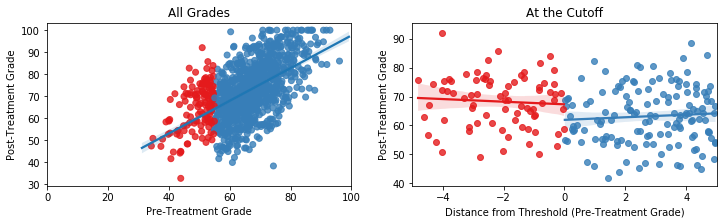

Resampled difference of the regression slopes at the cutoff: 10.00


In [5]:
cmap= sns.color_palette('Set1')
c1='#%02x%02x%02x' %  (np.round(cmap[0][0]*255).astype(int),np.round(cmap[0][1]*255).astype(int),np.round(cmap[0][2]*255).astype(int))
c2='#%02x%02x%02x' %  (np.round(cmap[1][0]*255).astype(int),np.round(cmap[1][1]*255).astype(int),np.round(cmap[1][2]*255).astype(int))
f, axes = plt.subplots(1,2, figsize=(12, 3))

print('Running bootstraps')
samp=np.zeros((nrand,))
for ni in range(nrand):
    print('\r %d/%d' % (ni+1,nrand),end='')
    students=make_student_dist(n,True,threshold,pilot_effect) # Changed from False
   
    plt.cla()
    sns.regplot(x="Distance", y="Post-Grade", color=c2,data=students.loc[students['Distance']<5].loc[students['Distance']>=0],ax=axes[1],truncate =True)
    t=sns.regplot(x="Distance", y="Post-Grade", color=c1,data=students.loc[students['Distance']>-5].loc[students['Distance']<=0],ax=axes[1],truncate =True)
    samp[ni]=t.get_lines()[1].get_ydata()[-1]-t.get_lines()[0].get_ydata()[0]
print(' ')


students.at[:,'color']= np.where( students['Treatment']==1 , c1,c2)

plt.cla()
axes[0].set_title('All Grades')
sns.regplot(x="Grade", y="Post-Grade", scatter_kws={'facecolors':students['color'],'edgecolors':students['color']},data=students,ax=axes[0])

plt.cla()
axes[1].set_title('At the Cutoff')
sns.regplot(x="Distance", y="Post-Grade", color=c2,data=students.loc[students['Distance']<5].loc[students['Distance']>=0],ax=axes[1],truncate =True)

t=sns.regplot(x="Distance", y="Post-Grade", color=c1,data=students.loc[students['Distance']>-5].loc[students['Distance']<=0],ax=axes[1],truncate =True)
axes[1].set_xlim(-5,5)
axes[1].set_xlabel('Distance from Threshold (Pre-Treatment Grade)')
axes[0].set_xlim(0,100)
axes[0].set_ylabel('Post-Treatment Grade')
axes[0].set_xlabel('Pre-Treatment Grade')
axes[1].set_ylabel('Post-Treatment Grade')


plt.show()

print('Resampled difference of the regression slopes at the cutoff: %.2f' % np.mean(samp))

So we are back on track to identifying our result! 

-------------------------------------------------------------------------------------------------------------------------------

But Regression Discontinuity only really holds at the cutoff point. As you get further and further away, there is less and less support for your conclusions. If our intervention helped lower acheiving students more, then we would underestimate our effect. Here students gain either 10,5 or 0 to their grade (when they start below 40, 50, or 55 respectively).

Again, for simplicity we are just looking at the difference of the slopes' intercept at the threshold

Running bootstraps
 500/500 


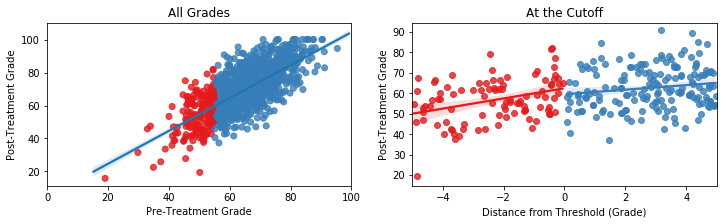

Resampled difference of the regression slopes at the cutoff: -0.11


In [6]:
pilot_effect_below40= 10 # how much a grade is improved with the intervention (if grade < 40)
pilot_effect_below50= 5 # how much a grade is improved with the intervention (if grade < 50)
pilot_effect_below55= 0 # how much a grade is improved with the intervention (if grade < 55)
all_treatment=True
cmap= sns.color_palette('Set1')
c1='#%02x%02x%02x' %  (np.round(cmap[0][0]*255).astype(int),np.round(cmap[0][1]*255).astype(int),np.round(cmap[0][2]*255).astype(int))
c2='#%02x%02x%02x' %  (np.round(cmap[1][0]*255).astype(int),np.round(cmap[1][1]*255).astype(int),np.round(cmap[1][2]*255).astype(int))

print('Running bootstraps')
samp=np.zeros((nrand,))
f, axes = plt.subplots(1,2, figsize=(12, 3))
for ni in range(nrand):
    print('\r %d/%d' % (ni+1,nrand),end='')
    
    students=pd.DataFrame(index=np.arange(n),columns=['Grade','Treatment','Post-Grade'])
    students['Grade']=np.random.normal(m,v,n)
    students['Treatment']=0
    students['Treatment'].loc[students['Grade']<threshold]=1
    if not all_treatment:
        students['Treatment']=students['Treatment']*np.random.randint(0,2,n)
    students['Post-Grade']=students['Grade']+\
    np.random.normal(deltam,deltav,n)
    students['Post-Grade'].loc[students['Grade']<55].loc[students['Treatment']==1]=\
        students['Post-Grade'].loc[students['Grade']<55].loc[students['Treatment']==1]+pilot_effect_below55
    students['Post-Grade'].loc[students['Grade']<50].loc[students['Treatment']==1]=\
        students['Post-Grade'].loc[students['Grade']<50].loc[students['Treatment']==1]+pilot_effect_below50
    students['Post-Grade'].loc[students['Grade']<40].loc[students['Treatment']==1]=\
        students['Post-Grade'].loc[students['Grade']<4].loc[students['Treatment']==1]+pilot_effect_below40

    students['Grade'].loc[students['Grade']>100]=100
    students['Post-Grade'].loc[students['Post-Grade']>100]=100
    students['Grade']=students['Grade'].astype(np.float32).copy(True)
    students['Grade'].loc[students['Grade']<0]=0
    students['Post-Grade'].loc[students['Post-Grade']<0]=0
    students['Post-Grade']=students['Post-Grade'].astype(np.float32).copy(True)
    students['Distance']=students['Grade']-threshold
    
    
    plt.cla()
    sns.regplot(x="Distance", y="Post-Grade", color=c2,data=students.loc[students['Distance']<5].loc[students['Distance']>=0],ax=axes[1],truncate =True)
    t=sns.regplot(x="Distance", y="Post-Grade", color=c1,data=students.loc[students['Distance']>-5].loc[students['Distance']<=0],ax=axes[1],truncate =True)
    samp[ni]=t.get_lines()[1].get_ydata()[-1]-t.get_lines()[0].get_ydata()[0]
print(' ')


students.at[:,'color']= np.where( students['Treatment']==1 , c1,c2)

sns.regplot(x="Grade", y="Post-Grade", scatter_kws={'facecolors':students['color'],'edgecolors':students['color']},data=students,ax=axes[0])

axes[0].set_title('All Grades')
axes[1].set_title('At the Cutoff')
plt.cla()
axes[1].set_title('At the Cutoff')
sns.regplot(x="Distance", y="Post-Grade", color=c2,data=students.loc[students['Distance']<5].loc[students['Distance']>=0],ax=axes[1],truncate =True)


t=sns.regplot(x="Distance", y="Post-Grade", color=c1,data=students.loc[students['Distance']>-5].loc[students['Distance']<=0],ax=axes[1],truncate =True)
axes[1].set_xlim(-5,5)
axes[1].set_xlabel('Distance from Threshold (Grade)')
axes[0].set_xlim(0,100)
axes[0].set_ylabel('Post-Treatment Grade')
axes[0].set_xlabel('Pre-Treatment Grade')
axes[1].set_ylabel('Post-Treatment Grade')



plt.show()

print('Resampled difference of the regression slopes at the cutoff: %.2f' % np.mean(samp))


So we lose our ability to detect the very beneficial contribution to the students who are struggling the most!

## Confounding Variables

So far we have been assuming that all students are the same, they fluctuate their grades the same, they participate in programs the same. Let's make it a little more complicated - now there are two types of students: type A are students who study, are motivated, and generally increase their grades as the year progresses (~10% on average), type B are students who generally lose interest and allow their grades to fall as the course goes on (~10% on average).

For our program we email everyone the same invitation to partake in extra-curricular help if they score below 55%. We can't 'force' them to go, we just present the opportunity to all of the students who get below 55% equally. In our example, unfortunately the intervention is so demoralizing that the 'true' effect is a decrease of 5%. 

We tried to reach everyone (no one left behind), and since it is optional, we have piloted and not piloted, so we can simply compare who went with who did not go, right?

Here is where we introduce a realistic confound: it just so happens that motivated type As are much more likely to actually 'participate' in the extra-curricular help. This makes things difficult to evaluate because now students have an effect on their final grades, the program has an effect on their final grades, AND the students have an effect on their program:

Program --> Grade
 
    ^        ^
    \        /    
     Students

In [7]:
pilot_effect= -5 # how much a grade is improved with the intervention
type_A_effect=10
type_B_effect=-10

def make_student_dist(n,threshold,pilot_effect,type_A_effect,type_B_effect):
    students=pd.DataFrame(index=np.arange(n),columns=['Grade','Treatment','Post-Grade'])
    students['Grade']=np.random.normal(m,v,n)
    students['Treatment']=0
    students['Type']=np.random.randint(0,2,n)
    temp=np.random.rand(n)
    students['Treatment'].loc[students['Type']==0]=(temp[students['Type']==0]>.35).astype(int)
    students['Treatment'].loc[students['Type']==1]=(temp[students['Type']==1]>.65).astype(int)
    students['Treatment'].loc[students['Grade']>=threshold]=0
    students['Treatment']=np.round(students['Treatment'].astype(int))
    students['Post-Grade']=students['Grade']+\
        np.random.normal(deltam,deltav,n)+pilot_effect*students['Treatment']
    students['Post-Grade'].loc[students['Type']==0]=students['Post-Grade'].loc[students['Type']==0]+\
        np.random.normal(type_A_effect,2,np.sum(students['Type']==0))
    students['Post-Grade'].loc[students['Type']==1]=students['Post-Grade'].loc[students['Type']==1]+\
        np.random.normal(type_B_effect,2,np.sum(students['Type']==1))
    students['Grade'].loc[students['Grade']>100]=100
    students['Post-Grade'].loc[students['Post-Grade']>100]=100
    students['Grade']=students['Grade'].astype(np.float32).copy(True)
    students['Grade'].loc[students['Grade']<0]=0
    students['Post-Grade'].loc[students['Post-Grade']<0]=0
    students['Post-Grade']=students['Post-Grade'].astype(np.float32).copy(True)
    students['Distance']=students['Grade']-threshold
    return students

Running bootstraps
 500/500 
Plotting the last bootstrap (for illustration)


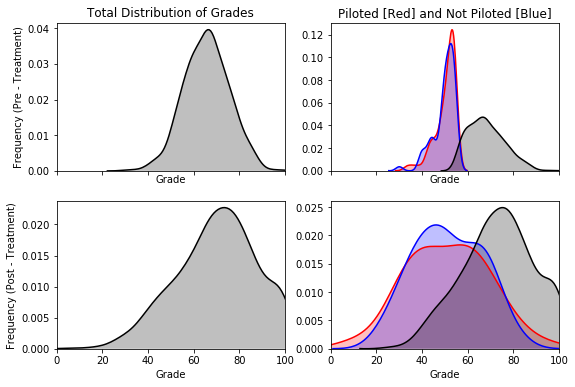

Resampled difference of means between [participated] and [invited but did not participate]: 1.10, true effect: -5.00


In [8]:
print('Running bootstraps')
samp=np.zeros((nrand,))
for ni in range(nrand):
    print('\r %d/%d' % (ni+1,nrand),end='')
    students=make_student_dist(n,threshold,pilot_effect,type_A_effect,type_B_effect)   
    samp[ni]=np.mean(students['Post-Grade'].loc[students['Treatment']==1])-\
        np.mean(students['Post-Grade'].loc[students['Treatment']==0].loc[students['Grade']<threshold])
#    dm=students[['Treatment','Post-Grade']].groupby('Treatment').mean()
#    samp[ni]=dm['Post-Grade'].loc[1]-dm['Post-Grade'].loc[0]

print(' ')
students=make_student_dist(n,threshold,pilot_effect,type_A_effect,type_B_effect)
print('Plotting the last bootstrap (for illustration)')

cmap= sns.color_palette('Set1')
f, axes = plt.subplots(2,2, figsize=(9, 6), sharex=True)

variables=[['Grade','Grade'],['Post-Grade','Post-Grade']]
titles=[['Total Distribution of Grades','Piloted [Red] and Not Piloted [Blue]'],
        ['','']]
y_labels=[['Frequency (Pre - Treatment)',''],['Frequency (Post - Treatment)','']]

for r in range(2):
    for c in range(2):
        if c==0:
            sns.distplot(students[variables[r][c]], hist=False,color='k',kde_kws={"shade": True},ax=axes[r,c])
        else:
            sns.distplot(students[variables[r][c]].loc[students['Treatment']==1].loc[students['Grade']<threshold], 
                         hist=False, color='r', kde_kws={"shade": True},ax=axes[r,c])
            sns.distplot(students[variables[r][c]].loc[students['Treatment']==0].loc[students['Grade']<threshold], 
                         hist=False, color='b', kde_kws={"shade": True},ax=axes[r,c])
            sns.distplot(students[variables[r][c]].loc[students['Treatment']==0].loc[students['Grade']>threshold], 
                         hist=False, color='k', kde_kws={"shade": True},ax=axes[r,c])
        axes[r,c].set_title(titles[r][c])
        axes[r,c].set_ylabel(y_labels[r][c])
        axes[r,c].set_xlabel('Grade')
        axes[r,c].set_xlim([0,100])

plt.show()

print('Resampled difference of means between [participated] and [invited but did not participate]: %.2f, true effect: %.2f' % (np.mean(samp),pilot_effect))


Well, without any controls, we erroneously conclude that our intervention is a success(!) This is because the students who went were already more likely to do better based on covarying attributes. We used their confounding increase to justify a program that actually decreased their grades!

This bias because students self-selected whether or not to participate also find the reverse. Reversing the effect of the pilot, and the effect of the type of student on the final grade (if the pilot is successful but the students who decrease their grade participate):

Running bootstraps
 500/500 
Plotting the last bootstrap (for illustration)


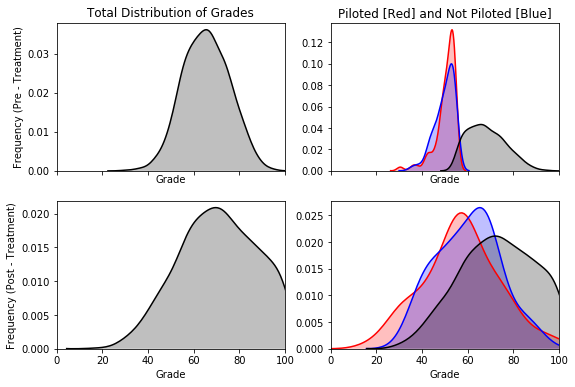

Resampled difference of means between [participated] and [invited but did not participate]: -1.04, true effect: 5.00


In [9]:
pilot_effect= 5 # how much a grade is improved with the intervention
type_A_effect=-10
type_B_effect=10

print('Running bootstraps')
samp=np.zeros((nrand,))
for ni in range(nrand):
    print('\r %d/%d' % (ni+1,nrand),end='')
    students=make_student_dist(n,threshold,pilot_effect,type_A_effect,type_B_effect)   
    samp[ni]=np.mean(students['Post-Grade'].loc[students['Treatment']==1])-\
        np.mean(students['Post-Grade'].loc[students['Treatment']==0].loc[students['Grade']<threshold])
#    dm=students[['Treatment','Post-Grade']].groupby('Treatment').mean()
#    samp[ni]=dm['Post-Grade'].loc[1]-dm['Post-Grade'].loc[0]

print(' ')
students=make_student_dist(n,threshold,pilot_effect,type_A_effect,type_B_effect)
print('Plotting the last bootstrap (for illustration)')

cmap= sns.color_palette('Set1')
f, axes = plt.subplots(2,2, figsize=(9, 6), sharex=True)

variables=[['Grade','Grade'],['Post-Grade','Post-Grade']]
titles=[['Total Distribution of Grades','Piloted [Red] and Not Piloted [Blue]'],
        ['','']]
y_labels=[['Frequency (Pre - Treatment)',''],['Frequency (Post - Treatment)','']]

for r in range(2):
    for c in range(2):
        if c==0:
            sns.distplot(students[variables[r][c]], hist=False,color='k',kde_kws={"shade": True},ax=axes[r,c])
        else:
            sns.distplot(students[variables[r][c]].loc[students['Treatment']==1].loc[students['Grade']<threshold], 
                         hist=False, color='r', kde_kws={"shade": True},ax=axes[r,c])
            sns.distplot(students[variables[r][c]].loc[students['Treatment']==0].loc[students['Grade']<threshold], 
                         hist=False, color='b', kde_kws={"shade": True},ax=axes[r,c])
            sns.distplot(students[variables[r][c]].loc[students['Treatment']==0].loc[students['Grade']>threshold], 
                         hist=False, color='k', kde_kws={"shade": True},ax=axes[r,c])
        axes[r,c].set_title(titles[r][c])
        axes[r,c].set_ylabel(y_labels[r][c])
        axes[r,c].set_xlabel('Grade')
        axes[r,c].set_xlim([0,100])

plt.show()

print('Resampled difference of means between [participated] and [invited but did not participate]: %.2f, true effect: %.2f' % (np.mean(samp),pilot_effect))


## Other Options

Another type of pilot study suitable when we can't ignore a portion of students as 'controls', but also maintain some aspect of randomness is a Randomized Encouragement Design. In this design, while everybody who is identified has the ability to participate in the treatment, you randomly make it easier for a subset. As an example, say the intervention is to meet as a group to discuss study habits. Everyone identified as potentially needing this intervention is given information on how to find a study group that fits their timetable, while a subset is given a selection of hyperlinks to automatically take them to a study group registration site. In this way, we are counting on some students who did not get 'encouraged' to participate anyways, and some students who were 'encouraged' to not participate. Everyone has the opportunity, but in this way we will get a sampling of all the students.

This sampling aspect is critical, because if everyone is given the same encouragement, then we will get a selection bias where the most motivated to improve will be more likely to register, and their motivation will bias our estimate of the intervention (as we saw above). In other words, was it the fact that they went to the intervention or is it simply that the type of student who goes to interventions is more likely to improve?

Randomized encouragement designs allow you to tease apart the estimate of the students on their grades, and the students on the pilot program, and the pilot program on the grades.

One final benefit to this treatment is that it allows you to control for as many variables as you can (with careful planning). Want to implement a program through email (perhaps referring to a service within the email)? Make sure to email everyone that you want to compare. Why? Perhaps the simple act of being singled out in an email is causing an impact and not the program itself.

# Final Thoughts

What would be easy controls at the planning stage become major headaches at the evaluation stage if not considered. Depending on the type of program, there are options and design choices that will allow you to accurately measure the effect, and support the projects that do the most good.
 
Thinking of running a pilot program? Talk to your local OIPA office today!